In [1]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

Data set is taken from kaggle(https://www.kaggle.com/aiswaryaramachandran/english-to-hindi-neural-machine-translation?select=Hindi_English_Truncated_Corpus.csv) and is preprocessed to train the Encoder Decoder model. 

In [3]:
train_df=pd.read_csv('Hindi_English_Truncated_Corpus.csv') 
print(train_df.shape)
train_df.head()

(127607, 3)


,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [4]:
train_df['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [5]:
def decontractions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

In [6]:
def clean_text(phrase):
    phrase = re.sub('[$)\?"’.°!;\'€%:|,।(/”/“]*', '', phrase)
    phrase = re.sub('[२३०८१५७९४६]*', '', phrase)
    phrase = re.sub('[0-9]', '', phrase)
    phrase = re.sub('[-]', ' ', phrase)
    return phrase

In [7]:
def preprocess_text_hindi(text_data):
    preprocessed_text = []
    for sentance in tqdm(text_data):
        sent = clean_text(sentance)
        preprocessed_text.append(sent.strip())
    return preprocessed_text

In [8]:
hindi_p=preprocess_text_hindi(train_df['hindi_sentence'])

100%|██████████| 127607/127607 [00:08<00:00, 14366.11it/s]


In [9]:
def preprocess_text_english(text_data):
    preprocessed_text = []
    for sentance in tqdm(text_data):
        sent = decontractions(str(sentance))
        sent = clean_text(sent)
        sent = ' '.join(e.lower() for e in sent.split())
        preprocessed_text.append(sent.strip())
    return preprocessed_text

In [10]:
english_p=preprocess_text_english(train_df['english_sentence'])

100%|██████████| 127607/127607 [00:10<00:00, 12113.68it/s]


In [11]:
train_df['processed_hindi']=hindi_p
train_df['processed_english']=english_p

In [12]:
train_df.head(20)

,source,english_sentence,hindi_sentence,processed_hindi,processed_english
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...,politicians do not have permission to do what ...
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,i would like to tell you about one such child
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है,this percentage is even greater than the perce...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,what we really mean is that they are bad at no...
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है,the ending portion of these vedas is called up...
5,tides,The then Governor of Kashmir resisted transfer...,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...,the then governor of kashmir resisted transfer...
6,indic2012,In this lies the circumstances of people befor...,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं,in this lies the circumstances of people befor...
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं,और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं,and who are we to say even that they are wrong
8,indic2012,“”Global Warming“” refer to warming caused in ...,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई...,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई...,global warming refer to warming caused in rece...
9,tides,You may want your child to go to a school that...,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...,you may want your child to go to a school that...


In [13]:
def find_length(sentence):
    return len(sentence.split())

train_df['len_processed_hindi'] = train_df['processed_hindi'].apply(find_length)
train_df['len_processed_english'] = train_df['processed_english'].apply(find_length)

<AxesSubplot:xlabel='len_processed_english', ylabel='Count'>

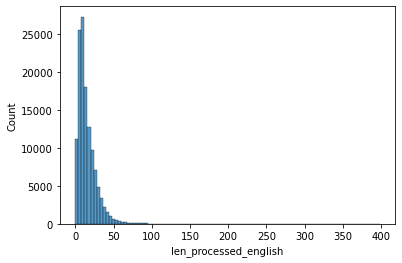

In [14]:
sns.histplot(train_df['len_processed_english'],bins=100)

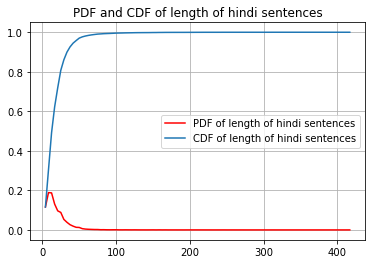

In [15]:
count, bins_count = np.histogram(train_df['len_processed_hindi'], bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

plt.title('PDF and CDF of length of hindi sentences')
plt.plot(bins_count[1:], pdf, color="red", label="PDF of length of hindi sentences")
plt.plot(bins_count[1:], cdf, label="CDF of length of hindi sentences")
plt.legend()
plt.grid()

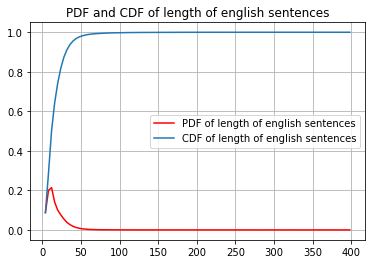

In [16]:
count, bins_count = np.histogram(train_df['len_processed_english'], bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

plt.title('PDF and CDF of length of english sentences')
plt.plot(bins_count[1:], pdf, color="red", label="PDF of length of english sentences")
plt.plot(bins_count[1:], cdf, label="CDF of length of english sentences")
plt.legend()
plt.grid()

### Observation
#### Mejority of the sentences are of length 10 to 15 in both english and hindi corpus.

In [17]:
train_df['encoder_input']='<start> '+train_df['processed_english']+' <end>'
train_df['decoder_input']='<start> '+train_df['processed_hindi']+' <end>'
train_df['decoder_output']= train_df['processed_hindi']+' <end>'+' <end>'

In [18]:
train_df.head()

,source,english_sentence,hindi_sentence,processed_hindi,processed_english,len_processed_hindi,len_processed_english,encoder_input,decoder_input,decoder_output
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...,politicians do not have permission to do what ...,13,12,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,i would like to tell you about one such child,11,10,<start> i would like to tell you about one suc...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है,this percentage is even greater than the perce...,9,10,<start> this percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक ह...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,what we really mean is that they are bad at no...,11,13,<start> what we really mean is that they are b...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते...
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है,the ending portion of these vedas is called up...,8,9,<start> the ending portion of these vedas is c...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है <en...


In [19]:
df=train_df[['source','encoder_input','decoder_input','decoder_output']] #storing required columns after preprocessing

df.to_csv('procedded_data.csv',index=False)
df_p=pd.read_csv('procedded_data.csv')
df_p.head()

,source,encoder_input,decoder_input,decoder_output
0,ted,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...
1,ted,<start> i would like to tell you about one suc...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,<start> this percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक ह...
3,ted,<start> what we really mean is that they are b...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते...
4,indic2012,<start> the ending portion of these vedas is c...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है <en...
